In [1]:
#visualisasi
import plotly.express as px
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

#preprosessing
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from collections import Counter
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

#encoder
from sklearn.preprocessing import LabelEncoder

#split data
from sklearn.model_selection import train_test_split

#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#pilih model
from lazypredict.Supervised import LazyClassifier

#evaluation model
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report    
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RanggaSaputra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_path = './data/'

## Fungsi dalam code ini

In [3]:
# Fungsi untuk hitung huruf
def count_word(text):
    #split teks menjadi kata-kata
    words = text.split()

    #hitung frekuensi masing-masing kata
    word_freq = Counter(words)

    #membuat dataFrame dari frekuensi kata
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Kata', 'Frekuensi'])

    #menyusun frekuensi kata tertinggi
    word_freq_df = word_freq_df.sort_values(by='Frekuensi', ascending=False)

    return word_freq_df

In [4]:
# Fungsi untuk preprosessing
def clear_word(caption):
    # Casefolding
    caption = caption.lower()
    
    #stemm
    caption = stemmer.stem(caption)

    # Remove angka
    caption = re.sub('[0-9]+', '', str(caption))

    # Remove hyperlinks
    caption = re.sub(r'https?:\/\/\S+', '', str(caption))

    # Remove hashtags
    caption = re.sub(r'#[A-Za-z0-9_]+', '', str(caption))

    # Remove symbol
    caption = re.sub(r'[^\x00-\x7f]', '', str(caption))
    
    # Remove mention and link
    caption = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", caption)

    # Remove comma
    caption = re.sub(r',',' ', str(caption))

    # Remove double huruf
    caption = re.sub(r'(\w)\1+', r'\1', caption)

    # Remove punctuation
    caption = re.sub(r'[^\w\s]', '', str(caption))

    # Remove newline
    caption = re.sub(r'\n', '', str(caption))

    # Remove spasi ganda
    caption = re.sub(r'\s+', ' ', str(caption))

    return caption

In [5]:
# hapus baris yang hanya ada 1 baris
def remove_sentence(caption): 
        word = caption.split()
        wordCount = len(word)
        if(wordCount<=1):
            caption = ''

        return caption

In [6]:
import json

slangword = {}

with open(data_path+'combined_slang_words.txt', 'r') as f:
    slangword = json.load(f)

#buat slangword
def replace_slang_words(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    new_words = []
    for word in words:
        if word in slangword:
            new_words.append(slangword[word])
        else:
            new_words.append(word)
    new_text = ' '.join(new_words)
    return new_text

In [7]:
kata_tambahan = ["pak", "bapak", "aku", "p"]

In [8]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def remove_stopwords(caption):
    return ' '.join([word for word in caption.split() if word not in kata_tambahan])

## cek data

In [9]:
#import pandas
import pandas as pd

#load data
df_tweet = pd.read_csv(data_path+'tweet.csv')
df_tweet.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [10]:
df_tweet = df_tweet.drop(columns=["Unnamed: 0"])
df_tweet.head()


,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [11]:
#cek null
df_tweet.isnull().sum()

sentimen    0
tweet       0
dtype: int64

## Wordcloud sebelum preprosessing

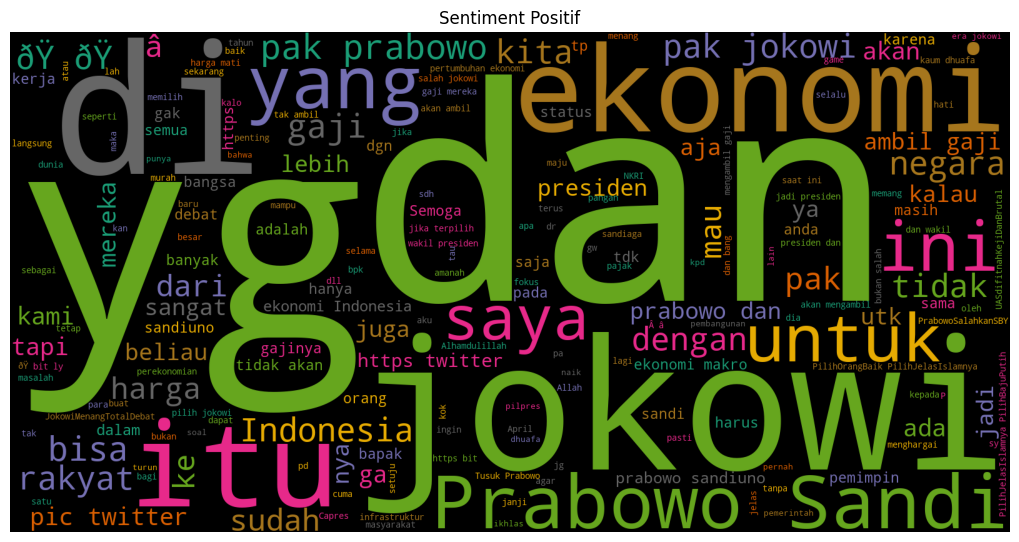

In [12]:
#worldcloud positif
data_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
word_positif = pd.Series(' '.join(data_positif['tweet']).split())
text_posi = ' '.join(word_positif)

# Display the generated image:
wordcloud_posi = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(wordcloud_posi)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
#cek frekuesin kata
freq_posi = count_word(text_posi)
freq_posi.head(15)

,Kata,Frekuensi
115,dan,330
43,yg,239
7,ekonomi,209
31,di,175
69,akan,142
83,yang,125
78,gaji,113
15,Jokowi,113
486,pak,110
42,itu,106


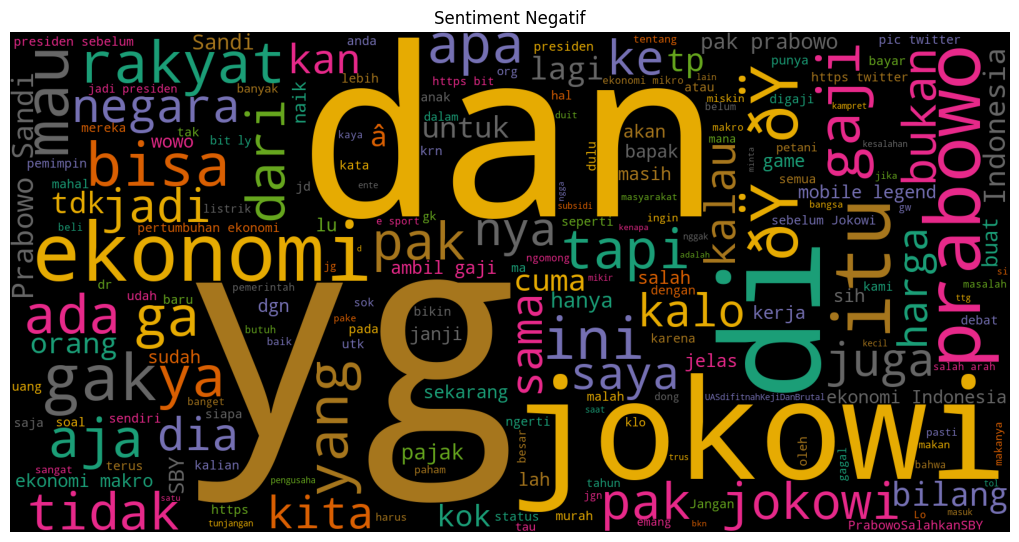

In [14]:
#worldcloud negatif
data_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
word_negatif = pd.Series(' '.join(data_negatif['tweet']).split())
text_neg = ' '.join(word_negatif)

# Display the generated image:
wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_neg)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [15]:
#cek frekuesin kata
freq_nega = count_word(text_neg)
freq_nega.head(15)

,Kata,Frekuensi
99,yg,261
72,ekonomi,253
62,dan,166
163,di,165
36,itu,118
183,pak,100
233,Prabowo,88
38,bisa,87
66,gak,86
186,gaji,80


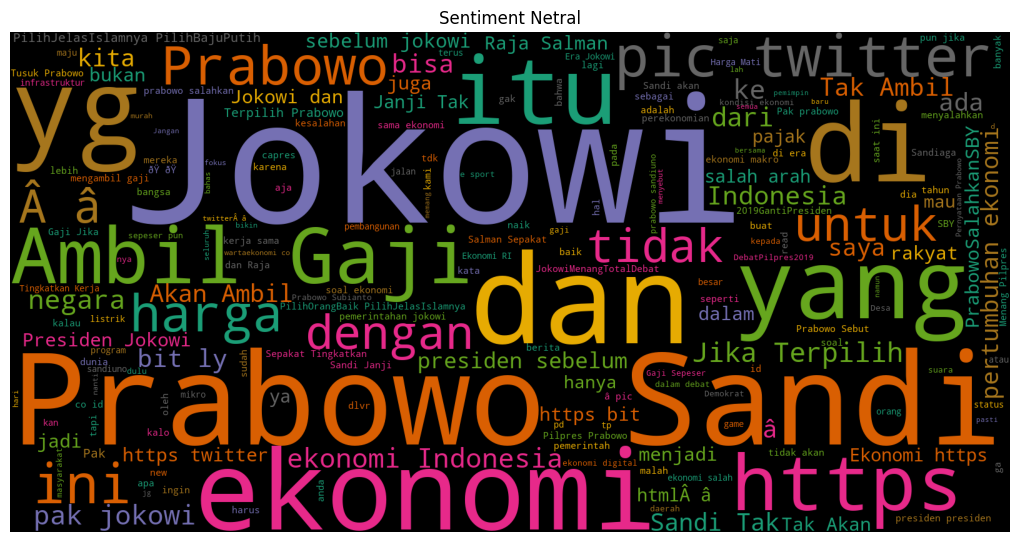

In [16]:
#worldcloud netral
data_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
word_netral = pd.Series(' '.join(data_netral['tweet']).split())
text_net = ' '.join(word_netral)

# Display the generated image:
wordcloud_netral = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_net)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(wordcloud_netral)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [17]:
#cek frekuesin kata
freq_net = count_word(text_net)
freq_net.head(15)

,Kata,Frekuensi
183,â€¦,192
14,ekonomi,192
216,dan,187
3,Jokowi,153
30,di,151
432,Prabowo,143
48,yg,121
222,Ekonomi,105
420,yang,91
15,Indonesia,74


## Preprosessing

In [18]:
df_tweet['tweet_clean'] = df_tweet['tweet'].apply(lambda x:replace_slang_words(x))
df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata @prabowo indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","batuan langka, tasbih jokowi hadiah dari habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","di era jokowi, ekonomi indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","bagi sumatera selatan, asian games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara kita hutang buat bangun infrastruktur y...


In [19]:
#stopword
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x: " ".join(stopword.remove(x) for x in x.split() ))
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x: remove_stopwords(x))

df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata @prabowo indonesia dihargai bangsa asing!...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...","batuan langka, tasbih jokowi hadiah habib luth..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....","era jokowi, ekonomi indonesia semakin baik. #0..."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...","sumatera selatan, asian games berdampak ekonom..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara hutang buat bangun infrastruktur dipake...


In [20]:
df_tweet['tweet_clean'] = df_tweet['tweet_clean'].apply(lambda x:clear_word(x))
df_tweet.head()

,sentimen,tweet,tweet_clean
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata prabowo indonesia harga bangsa asing beri...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batu langka tasbih jokowi hadiah habib luthfi ...
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia makin baik indone...
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asi games dampak ekonomi lang...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara hutang buat bangun infrastruktur dipake...


## Wordcloud setelah preprosessing

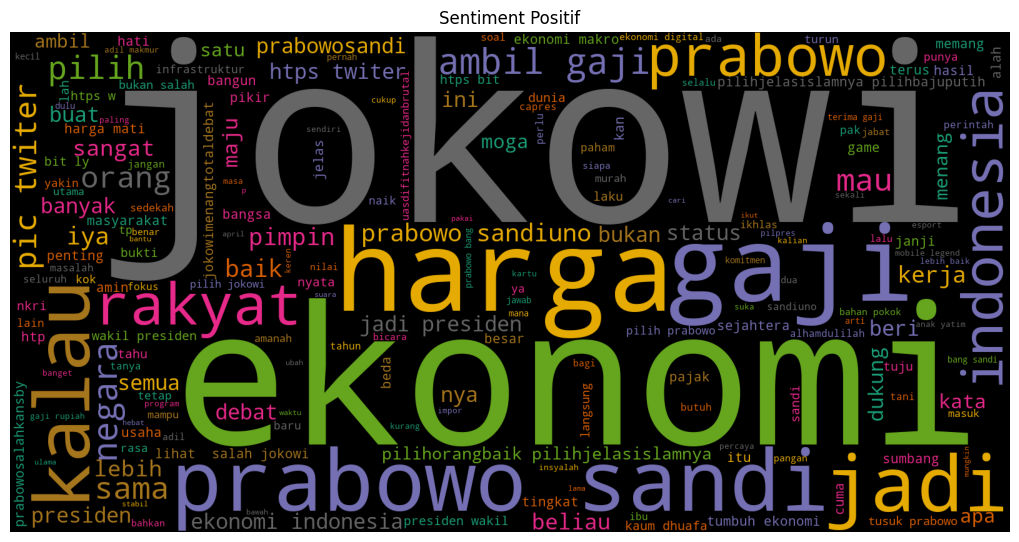

In [21]:
#worldcloud positif
data_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
word_positif = pd.Series(' '.join(data_positif['tweet_clean']).split())
text_posi = ' '.join(word_positif)

# Display the generated image:
wordcloud_posi = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(wordcloud_posi)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

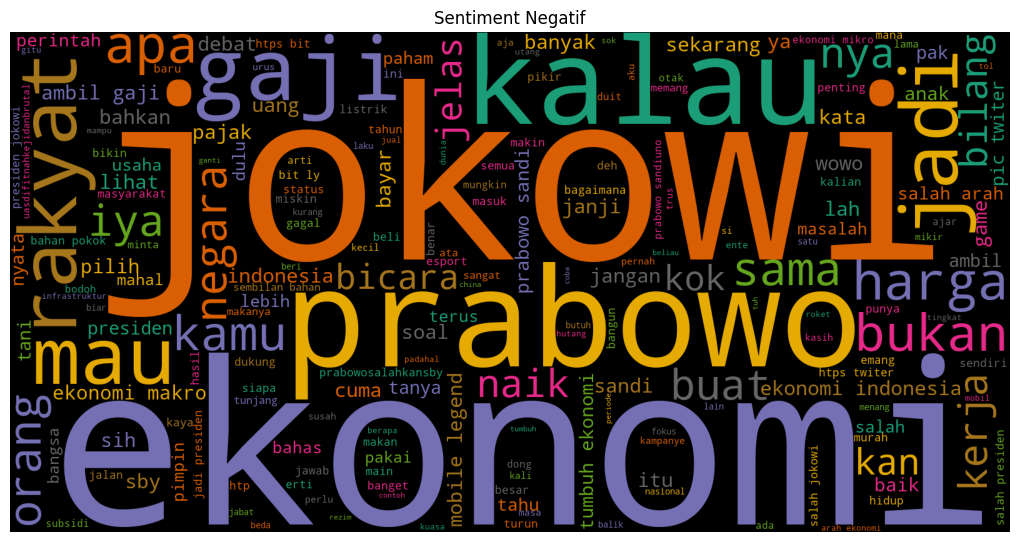

In [22]:
#worldcloud negatif
data_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
word_negatif = pd.Series(' '.join(data_negatif['tweet_clean']).split())
text_neg = ' '.join(word_negatif)

# Display the generated image:
wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_neg)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

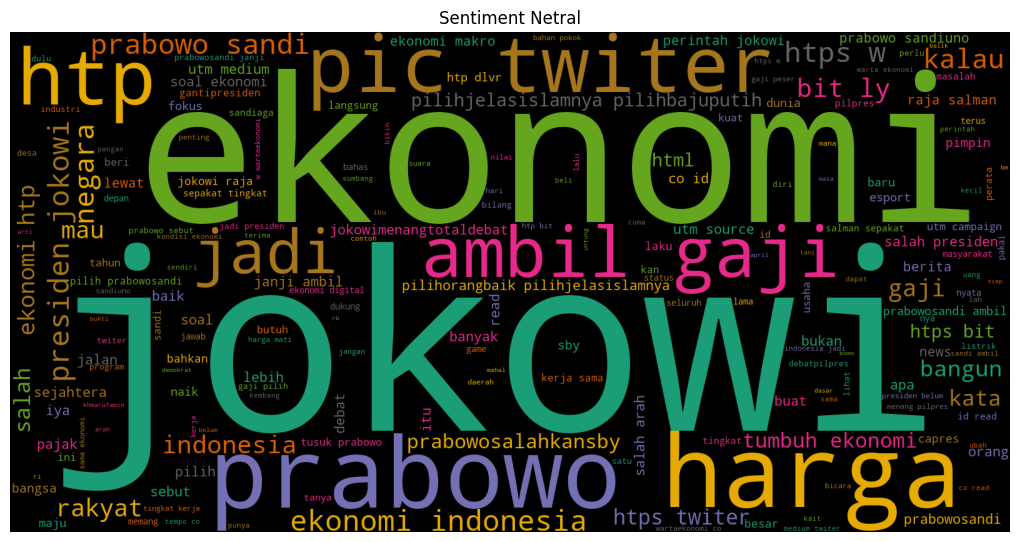

In [23]:
#worldcloud netral
data_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
word_netral = pd.Series(' '.join(data_netral['tweet_clean']).split())
text_net = ' '.join(word_netral)

# Display the generated image:
wordcloud_netral = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_net)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(wordcloud_netral)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Persiapan Deep learning

In [24]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 1000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Tokenize input texts
tokenizer = Tokenizer(oov_token='UNK', num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df_tweet['tweet_clean'].values)
word_index = tokenizer.word_index

# Convert input texts to sequences and pad them
X = tokenizer.texts_to_sequences(df_tweet['tweet_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor : ', X.shape)

Shape of data tensor :  (1815, 250)


In [25]:
Y = pd.get_dummies(df_tweet['sentimen']).values
print('Shape of label tensors: ', Y.shape)

Shape of label tensors:  (1815, 3)


## Jangan dijalanin ini buat cari parameter terbaik

In [26]:
import optuna
import keras
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import to_categorical

In [28]:
# Define your model creation function
def create_model(trial):
    X_shape = X.shape
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_shape[1]))
    model.add(Dropout(trial.suggest_uniform('dropout_rate', 0.0, 0.5)))
    model.add(LSTM(
        units=trial.suggest_int('lstm_units', 50, 200),
        dropout=trial.suggest_uniform('lstm_dropout', 0.0, 0.5),
        recurrent_dropout=trial.suggest_uniform('lstm_recurrent_dropout', 0.0, 0.5),
        input_shape=(X_shape[1], EMBEDDING_DIM)
    ))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-1))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define a function to optimize the model
def objective(trial):
    # Split data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    model = create_model(trial)

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    
    return -history.history['val_accuracy'][-1]  # We want to maximize accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the model
n_trials = 20  # Number of trials to run
study.optimize(objective, n_trials=n_trials)

# Print the best trial
best_trial = study.best_trial
print("Best trial:")
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-07 20:54:08,215] A new study created in memory with name: no-name-9b8b35cc-f320-43d8-81b4-182ec23e5c0c
[I 2023-11-07 21:57:49,656] Trial 0 finished with value: -0.5785123705863953 and parameters: {'dropout_rate': 0.405285767190001, 'lstm_units': 169, 'lstm_dropout': 0.030326003360928, 'lstm_recurrent_dropout': 0.1393060875652108, 'learning_rate': 0.0005921461941334083}. Best is trial 0 with value: -0.5785123705863953.
[I 2023-11-07 22:41:54,069] Trial 1 finished with value: -0.5482093691825867 and parameters: {'dropout_rate': 0.19946480155991458, 'lstm_units': 105, 'lstm_dropout': 0.04218010026316554, 'lstm_recurrent_dropout': 0.05551498626560192, 'learning_rate': 0.001194356813561264}. Best is trial 1 with value: -0.5482093691825867.
[I 2023-11-07 23:25:36,442] Trial 2 finished with value: -0.5647382736206055 and parameters: {'dropout_rate': 0.3433345583358223, 'lstm_units': 153, 'lstm_dropout': 0.11293384626144609, 'lstm_recurrent_dropout': 0.1986101236129294, 'learning_ra

KeyboardInterrupt: 

In [27]:
def create_model(trial):
    X_shape = X.shape
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_shape[1]))
    model.add(Dropout(trial.suggest_uniform('dropout_rate', 0.0, 0.5)))
    model.add(LSTM(
        units=trial.suggest_int('lstm_units', 50, 200),
        dropout=trial.suggest_uniform('lstm_dropout', 0.0, 0.5),
        recurrent_dropout=trial.suggest_uniform('lstm_recurrent_dropout', 0.0, 0.5),
        input_shape=(X_shape[1], EMBEDDING_DIM)
    ))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-1))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def objective(trial):
    # Split data into training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    model = create_model(trial)
    
    # Define a study to optimize the number of epochs
    study_epochs = optuna.create_study(direction="maximize")

    # Define the objective function for optimizing the number of epochs
    def epoch_objective(trial_epochs):
        num_epochs = trial_epochs.suggest_int("num_epochs", 5, 50)  # Suggest a range of epochs to try
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=32, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]
        return val_accuracy

    # Add the epoch objective to the study
    study_epochs.optimize(epoch_objective, n_trials=5)  # You can change n_trials as needed

    # Get the best number of epochs found by Optuna
    best_num_epochs = study_epochs.best_params["num_epochs"]

    # Train the model with the best number of epochs
    best_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_num_epochs, batch_size=32, verbose=0)
    
    return -best_history.history['val_accuracy'][-1]

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the model
n_trials = 20  # Number of trials to run
study.optimize(objective, n_trials=n_trials)

# Print the best trial
best_trial = study.best_trial
print("Best trial:")
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-07 16:31:05,484] A new study created in memory with name: no-name-d80dddec-e133-466a-bbea-0ac10eaf3117
[I 2023-11-07 16:31:05,986] A new study created in memory with name: no-name-9497f780-e6f1-43d0-8222-2b17bedae9ae
[I 2023-11-07 16:46:20,841] Trial 0 finished with value: 0.586776852607727 and parameters: {'num_epochs': 31}. Best is trial 0 with value: 0.586776852607727.
[I 2023-11-07 16:56:46,683] Trial 1 finished with value: 0.5757575631141663 and parameters: {'num_epochs': 21}. Best is trial 0 with value: 0.586776852607727.
[I 2023-11-07 17:02:45,864] Trial 2 finished with value: 0.5730027556419373 and parameters: {'num_epochs': 12}. Best is trial 0 with value: 0.586776852607727.
[I 2023-11-07 17:25:00,883] Trial 3 finished with value: 0.5482093691825867 and parameters: {'num_epochs': 43}. Best is trial 0 with value: 0.586776852607727.
[I 2023-11-07 17:33:34,013] Trial 4 finished with value: 0.5619834661483765 and parameters: {'num_epochs': 17}. Best is trial 0 with valu

KeyboardInterrupt: 

In [ ]:
# Assuming you have found the best trial
best_trial = study.best_trial

# Create the best model
best_model = create_model(best_trial)

# Train the best model on the entire dataset
best_model.fit(X, Y, epochs=best_num_epochs, batch_size=32)

# Make predictions with the best model
predictions = best_model.predict(new_data)

# If you want to save the best model
best_model.save("best_model_fix.h5")

## Langsung kesini aja ini model yang udh dituning

In [ ]:
best_model.save("best_model.h5")

In [28]:
from keras.models import load_model

# Ganti 'nama_model.h5' dengan nama file model Anda
model = load_model('best_model.h5')

In [29]:
model.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_104 (Embedding)   (None, 250, 100)          100000    
                                                                 
 spatial_dropout1d_104 (Spa  (None, 250, 100)          0         
 tialDropout1D)                                                  
                                                                 
 lstm_104 (LSTM)             (None, 171)               186048    
                                                                 
 dense_104 (Dense)           (None, 3)                 516       
                                                                 
Total params: 286564 (1.09 MB)
Trainable params: 286564 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
import tensorflow as tf
'''
ini untuk membuat variabel earlystopping,
disini pake akurasi jika nilai akurasiny kurang lebih sama
sebanyak tiga kali model bakal berhenti proses
'''
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
#history = model.fit(x_train, y_train, epochs=50, batch_size=10, validation_split=0.2, callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 [==============================] - 29s 784ms/step - loss: 1.0984 - accuracy: 0.3394 - val_loss: 1.0977 - val_accuracy: 0.3883
Epoch 2/50
37/37 [==============================] - 43s 1s/step - loss: 1.0977 - accuracy: 0.3609 - val_loss: 1.0973 - val_accuracy: 0.4021
Epoch 3/50
37/37 [==============================] - 45s 1s/step - loss: 1.0971 - accuracy: 0.3790 - val_loss: 1.0969 - val_accuracy: 0.4158
Epoch 4/50
37/37 [==============================] - 45s 1s/step - loss: 1.0968 - accuracy: 0.3764 - val_loss: 1.0964 - val_accuracy: 0.4536
Epoch 5/50
37/37 [==============================] - 50s 1s/step - loss: 1.0961 - accuracy: 0.3971 - val_loss: 1.0960 - val_accuracy: 0.4708
Epoch 6/50
37/37 [==============================] - 47s 1s/step - loss: 1.0959 - accuracy: 0.4091 - val_loss: 1.0954 - val_accuracy: 0.5052
Epoch 7/50
37/37 [==============================] - 47s 1s/step - loss: 1.0954 - accuracy: 0.4203 - val_loss: 1.0948 - val_accuracy: 0.5258
Epoch 8/50
37/37 

In [34]:
import matplotlib.pyplot as plt
from plotly.offline import iplot
import seaborn as sns

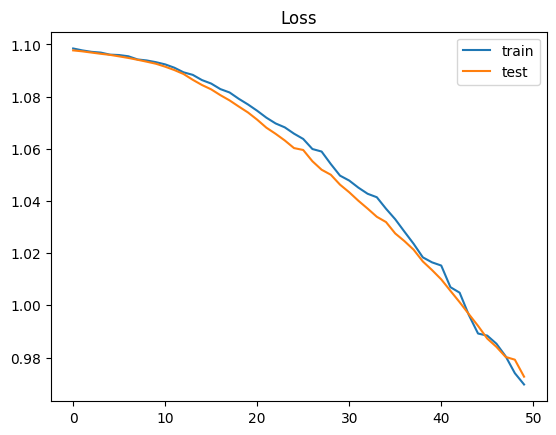

In [35]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

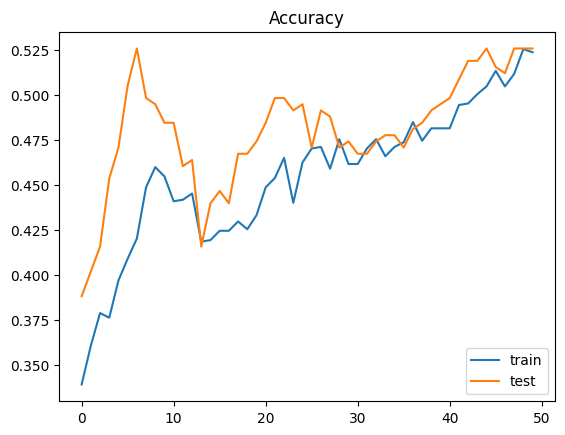

In [36]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## persiapan build model

In [24]:
# pisahkan antara label dan fitur 
y = df_tweet['sentimen']
X = df_tweet['tweet_clean']

In [47]:
# pembobotan menggunakan tf-idf 
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X)

# tranformasi teks ke tf-idf fitur
tfidf_matrix = vectorizer.transform(X)

# menubah dalam bentuk array
X_tdif = tfidf_matrix.toarray()

In [48]:
# encoding label 
enc = LabelEncoder() 
enc.fit(y.values)
y_enc=enc.transform(y.values)

In [49]:
# pisahkan train dan test
X_train_words, X_test_words, y_train, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=10)

X_train = vectorizer.transform(X_train_words)
X_train = X_train.toarray()

X_test = vectorizer.transform(X_test_words)
X_test = X_test.toarray()

## Machine Learning Konvesional

In [50]:
# Inisialisasi LazyClassifier
clf = LazyClassifier(predictions=True)

# Lakukan klasifikasi
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [50:23<00:00, 104.27s/it] 


In [52]:
models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.60,0.60,None,0.60,11.05
XGBClassifier,0.60,0.59,None,0.60,232.05
Perceptron,0.59,0.58,None,0.59,9.17
RandomForestClassifier,0.59,0.58,None,0.58,17.87
ExtraTreesClassifier,0.58,0.57,None,0.58,38.59
PassiveAggressiveClassifier,0.58,0.56,None,0.57,17.78
LogisticRegression,0.58,0.56,None,0.57,16.20
LinearSVC,0.57,0.56,None,0.57,310.36
AdaBoostClassifier,0.57,0.57,None,0.57,72.02
